In [1]:
import numpy as np
import tensorflow as tf
import gym
from ppo import PPO
from recorder import Recorder
from logRewards import DataLogger
import warnings
warnings.filterwarnings('ignore') #ignora warnings
seed=42

2025-01-04 19:36:35.101085: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1736015795.115900   41731 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1736015795.120240   41731 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-04 19:36:35.135348: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:

tf.random.set_seed(seed)
np.random.seed(seed)


# Configurazione ed esecuzione
#Lista di giochi a disposizione di Procgen:
""" 
    bigfish, bossfight, caveflyer, chaser, climber
    coinrun, dodgeball, fruitbot, heist, jumper
    leaper, maze, miner, ninja, plumber, starpilot
"""
seed=42
gameName="starpilot" #Scelto starpilot perchè è un gioco che ha episode corti, quindi allenamenti più rapidi.
env = gym.make('procgen:procgen-'+gameName+'-v0',distribution_mode='easy',start_level=seed,rand_seed=seed, num_levels=200, use_backgrounds=False)
recorder=Recorder(gameName)
dataLogger=DataLogger(gameName)
ppo=PPO(env,weightsPath=None,recorder=recorder,dataLogger=dataLogger,gameName=gameName)

I0000 00:00:1736015800.561745   41731 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 2787 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1650, pci bus id: 0000:01:00.0, compute capability: 7.5


--------- EXCEPTION :
All layers added to a Sequential model should have unique names. Name 'input_layer' is already the name of a layer in this model. Update the `name` argument to pass a unique name.
Errore nel caricamento dei pesi


Model: "actor_ppo"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ actor_ppo_conv1 (Conv2D)        │ (None, 62, 62, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ actor_ppo_pool1 (MaxPooling2D)  │ (None, 20, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ actor_ppo_conv2 (Conv2D)        │ (None, 18, 29, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ actor_ppo_pool2 (MaxPooling2D)  │ (None, 6, 14, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ actor_ppo_conv3 (Conv2D)        │ (None, 4, 12, 32)      │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ actor_ppo_pool3 (MaxPooling2D)  │ (None, 1, 6, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ actor_ppo_flatten (Flatten)     │ (None, 192)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ actor_ppo_dense (Dense)         │ (None, 128)            │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ actor_ppo_dense3 (Dense)        │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ actor_ppo_dense4 (Dense)        │ (None, 15)             │           495 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 48,719 (190.31 KB)

 Trainable params: 48,719 (190.31 KB)

 Non-trainable params: 0 (0.00 B)

Model: "critic_ppo"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ critic_ppo_conv1 (Conv2D)       │ (None, 62, 62, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ critic_ppo_pool1 (MaxPooling2D) │ (None, 20, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ critic_ppo_conv2 (Conv2D)       │ (None, 18, 29, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ critic_ppo_pool2 (MaxPooling2D) │ (None, 6, 14, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ critic_ppo_conv3 (Conv2D)       │ (None, 4, 12, 32)      │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ critic_ppo_pool3 (MaxPooling2D) │ (None, 1, 6, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ critic_ppo_flatten (Flatten)    │ (None, 192)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ critic_ppo_dense (Dense)        │ (None, 128)            │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ critic_ppo_dense3 (Dense)       │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ critic_ppo_dense4 (Dense)       │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 48,257 (188.50 KB)

 Trainable params: 48,257 (188.50 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:


for epoch in range(ppo.nEpochs):                                            # Main training loop for n epochs

        obs ,actions ,logp , returns, advs = ppo.rollout()                                  # Get Rollout and infos
        #Check if batches contains nan or inf values
        try:
                tf.debugging.check_numerics(tf.cast(obs, tf.float32), "obs_batch has nan or inf values")
        except:
                print("OBS BATCH HAS NAN OR INF VALUES")
                print(obs)

        try:
                tf.debugging.check_numerics(tf.cast(actions, tf.float32), "actions_batch has nan or inf values")
        except:
                print("ACTIONS BATCH HAS NAN OR INF VALUES")
                print(actions)
        
        try:
                tf.debugging.check_numerics(advs, "advs_batch has nan or inf values")
        except:
                print("ADVS BATCH HAS NAN OR INF VALUES")
                print(advs)

        try:
                tf.debugging.check_numerics(returns, "returns_batch has nan or inf values")
        except:
                print("returns BATCH HAS NAN OR INF VALUES")
                print(returns)
        
        
        try:
                tf.debugging.check_numerics(logp, "logp_t_batch has nan or inf values")
        except:
                print("logp BATCH HAS NAN OR INF VALUES")
                print(logp)

        
        print(f"Epoch: {epoch} | Rollout completed")                     # Print loss for each epoch
        print(obs.shape,actions.shape,logp.shape,returns.shape,advs.shape)
        total_loss = ppo.train(obs,actions,advs,returns,logp)                                         # Push rollout in ppo and update policy accordingly
        print(f"Epoch: {epoch} | Loss: {total_loss}")                     # Print loss for each epoch
        ppo.save_model(epoch=epoch)
        ppo.update_hyperparams(epoch=epoch)
        ppo.evaluate_model()

I0000 00:00:1736015801.439452   41731 cuda_dnn.cc:529] Loaded cuDNN version 90300


Reward per episode:  0.0  Episode length:  136
Reward per episode:  1.0  Episode length:  113
Reward per episode:  2.0  Episode length:  78
Reward per episode:  2.0  Episode length:  85
Reward per episode:  2.0  Episode length:  50
Reward per episode:  2.0  Episode length:  79
Reward per episode:  3.0  Episode length:  47
Reward per episode:  5.0  Episode length:  73
Reward per episode:  5.0  Episode length:  38
Reward per episode:  8.0  Episode length:  71
Reward per episode:  11.0  Episode length:  44
Reward per episode:  11.0  Episode length:  78
Reward per episode:  11.0  Episode length:  42
Epoch: 0 | Rollout completed
(1024, 64, 64, 3) (1024,) (1024,) (1024,) (1024,)
tf.Tensor(
[0.99847984 1.001972   0.9989999  1.0005814  0.9952232  1.005109
 1.0124942  1.0060099  0.9950624  1.0024527  1.0031403  1.0146106
 1.003734   0.99839294 0.99632937 1.0147623  1.0144696  1.0105147
 0.9749227  0.9876609  1.0004257  1.013076   1.0550053  1.024724
 0.96671426 0.9900755  0.99714494 0.9982013  

    Epoch  Average reward  Min reward  Max reward  Cumulative Reward
0      17             0.3         0.0         3.0                3.0
1      18             2.6         0.0         6.0               26.0
2      19             1.5         0.0         5.0               15.0
3      20             1.0         0.0         5.0               10.0
4      21             1.1         0.0         5.0               11.0
5      22             1.5         0.0         3.0               15.0
6      23             1.4         0.0         7.0               14.0
7      24             2.2         0.0         5.0               22.0
8      25             0.3         0.0         2.0                3.0
9      26             3.7         1.0         9.0               37.0
10     27             5.5         0.0         9.0               55.0
11     28             3.2         1.0         7.0               32.0
12     29             2.1         0.0         5.0               21.0
13     30             1.1         

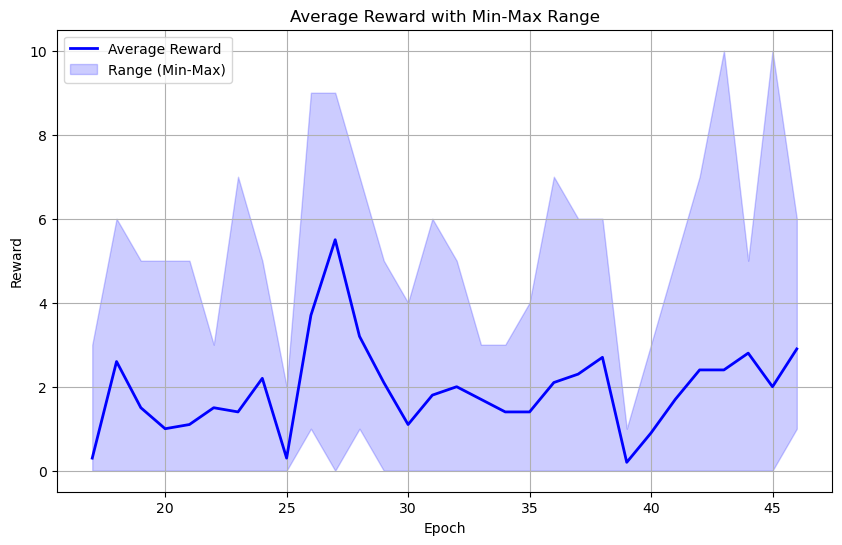

In [ ]:
#Show graphs

dataLogger.showGraphAverageReward()

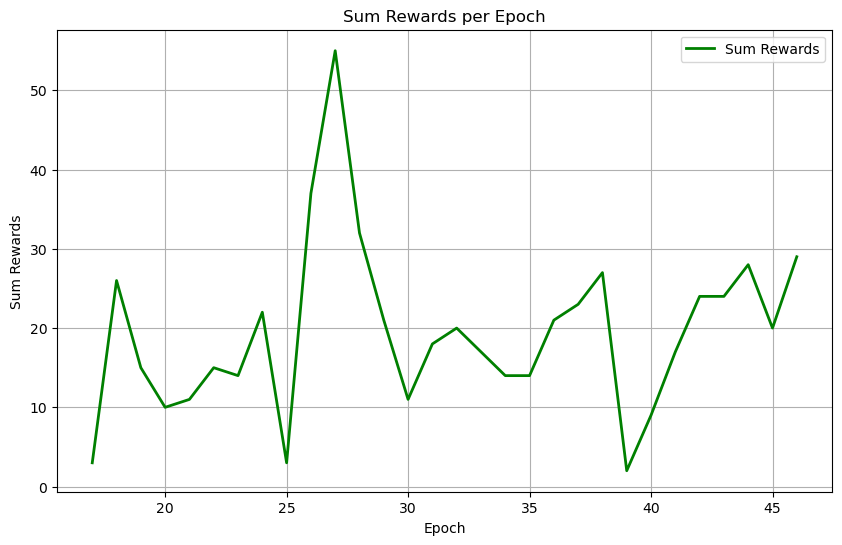

In [ ]:

dataLogger.showGraphCumulativeReward()